        encounter_id  patient_nbr             race  gender      age weight  \
0            2278392      8222157        Caucasian  Female   [0-10)      ?   
1             149190     55629189        Caucasian  Female  [10-20)      ?   
2              64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3             500364     82442376        Caucasian    Male  [30-40)      ?   
4              16680     42519267        Caucasian    Male  [40-50)      ?   
...              ...          ...              ...     ...      ...    ...   
101761     443847548    100162476  AfricanAmerican    Male  [70-80)      ?   
101762     443847782     74694222  AfricanAmerican  Female  [80-90)      ?   
101763     443854148     41088789        Caucasian    Male  [70-80)      ?   
101764     443857166     31693671        Caucasian  Female  [80-90)      ?   
101765     443867222    175429310        Caucasian    Male  [70-80)      ?   

        admission_type_id  discharge_disposition_id  admission_

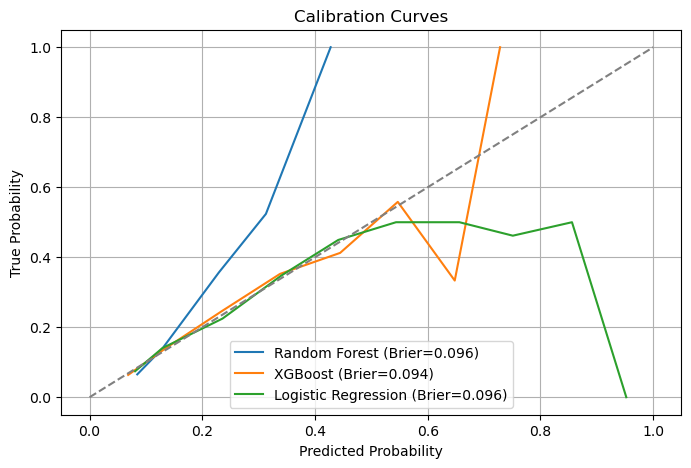

Top Features:
Feature 12: Importance 0.4680
Feature 4: Importance 0.1486
Feature 11: Importance 0.0768
Feature 13: Importance 0.0574
Feature 6: Importance 0.0350
Feature 16: Importance 0.0301
Feature 9: Importance 0.0257
Feature 15: Importance 0.0245
Feature 7: Importance 0.0202
Feature 2: Importance 0.0192
Clinical Utility Report:
[[18060    23]
 [ 2243    28]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.55      0.01      0.02      2271

    accuracy                           0.89     20354
   macro avg       0.72      0.51      0.48     20354
weighted avg       0.85      0.89      0.84     20354



In [12]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# 2. Load and preprocess dataset
df = pd.read_csv("diabetic_data.csv")
print(df)
df.drop(['weight', 'payer_code', 'medical_specialty', 'encounter_id', 'patient_nbr'], axis=1, inplace=True)
df.replace('?', pd.NA, inplace=True)
print(df)

# Encode categorical variables
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype(str)
    df[col] = le.fit_transform(df[col])

# Use SimpleImputer for speed
imputer = SimpleImputer(strategy='most_frequent')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Binary target: readmitted within 30 days
df_imputed['readmitted'] = df_imputed['readmitted'].apply(lambda x: 1 if x == le.transform(['<30'])[0] else 0)

# 3. Feature selection using variance threshold
from sklearn.feature_selection import VarianceThreshold
X = df_imputed.drop('readmitted', axis=1)
y = df_imputed['readmitted']
X_selected = VarianceThreshold(threshold=0.01).fit_transform(X)

# 4. Scale data and train/test split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# 5. Train lightweight models
rf = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
xgb = XGBClassifier(n_estimators=50, max_depth=3, eval_metric='logloss', random_state=42)
lr = LogisticRegression(max_iter=500)

models = {'Random Forest': rf, 'XGBoost': xgb, 'Logistic Regression': lr}
for name, model in models.items():
    model.fit(X_train, y_train)

# 6. Calibration curves and Brier scores
plt.figure(figsize=(8, 5))
for name, model in models.items():
    prob_pos = model.predict_proba(X_test)[:, 1]
    brier = brier_score_loss(y_test, prob_pos)
    print(f"{name} Brier Score: {brier:.4f}")
    prob_true, prob_pred = calibration_curve(y_test, prob_pos, n_bins=10)
    plt.plot(prob_pred, prob_true, label=f"{name} (Brier={brier:.3f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curves")
plt.legend()
plt.grid()
plt.show()

# 7. Feature importance (Random Forest only)
importances = rf.feature_importances_
print("Top Features:")
for i in importances.argsort()[::-1][:10]:
    print(f"Feature {i}: Importance {importances[i]:.4f}")

# 8. Clinical utility analysis
threshold = 0.5
preds = (xgb.predict_proba(X_test)[:, 1] > threshold).astype(int)
print("Clinical Utility Report:")
print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))